## Importing modules

In [2]:
import pickle
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.dates as mdates

import tensorflow as tf
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

from sys import argv
from re import findall
from requests import get
from dateutil.parser import parse
from datetime import date

## Scrape the web for dataset

In [4]:
URL = "https://finance.yahoo.com/quote/BTC-USD/history"
date_today = str(date.today())
date_from = int(parse("01-Jan-2015").timestamp())
date_to = int(parse(date_today).timestamp())
PARAMS = {"period1": date_from, "period2": date_to, "interval": "1d", "filter": "history", "frequency": "1d"}
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0 Safari/537.36"
}
REGEX = r"<tr.*?>.*?<td.*?>(.+?)<\/td>.*?<td.*?>(.+?)<\/td>.*?<td.*?>(.+?)<\/td>.*?<td.*?>(.+?)<\/td>.*?<td.*?>(.+?)<\/td>.*?<td.*?>(.+?)<\/td>.*?<td.*?>(.+?)<\/td>.*?<\/tr>"

response = get(URL, headers=HEADERS, params=PARAMS)
if response.status_code == 200:
    data = [
        [column.replace(",", "") for column in match]
        for match in findall(REGEX, response.text)
    ]
    data.sort(key=lambda x: parse(x[0]))  # Sort by date (oldest to newest)

    with open("price.csv", "w") as f:
        f.write("Date,Open,High,Low,Close,Adj Close,Volume\n")
        for row in data:
            f.write(",".join(row) + "\n")
else:
    print("Failed to retrieve data. Status code:", response.status_code)

## Load the dataset

In [6]:
df = pd.read_csv('price.csv')
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,310.91,320.19,310.21,320.19,320.19,13942900
2015-01-01,320.43,320.43,314.00,314.25,314.25,8036550
2015-01-02,314.08,315.84,313.57,315.03,315.03,7860650
2015-01-03,314.85,315.15,281.08,281.08,281.08,33054400
2015-01-04,281.15,287.23,257.61,264.20,264.20,55629100


In [7]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3587.000000,3587.00000,3587.000000,3587.000000,3587.000000,3.587000e+03
mean,18806.981324,19230.17034,18357.583613,18824.237600,18824.237600,1.826675e+10
std,20122.988480,20563.66886,19645.365638,20134.497072,20134.497072,1.918053e+10
min,176.900000,211.73000,171.510000,178.100000,178.100000,7.860650e+06
25%,2474.010000,2546.18500,2357.075000,2479.645000,2479.645000,1.067335e+09
50%,9471.210000,9655.07000,9263.070000,9477.640000,9477.640000,1.487253e+10
75%,30223.430000,30625.88000,29623.700000,30242.095000,30242.095000,2.927972e+10
max,73079.380000,73750.07000,71334.090000,73083.500000,73083.500000,3.509679e+11


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3587 entries, 2014-12-31 to 2024-10-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3587 non-null   float64
 1   High       3587 non-null   float64
 2   Low        3587 non-null   float64
 3   Close      3587 non-null   float64
 4   Adj Close  3587 non-null   float64
 5   Volume     3587 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 196.2 KB


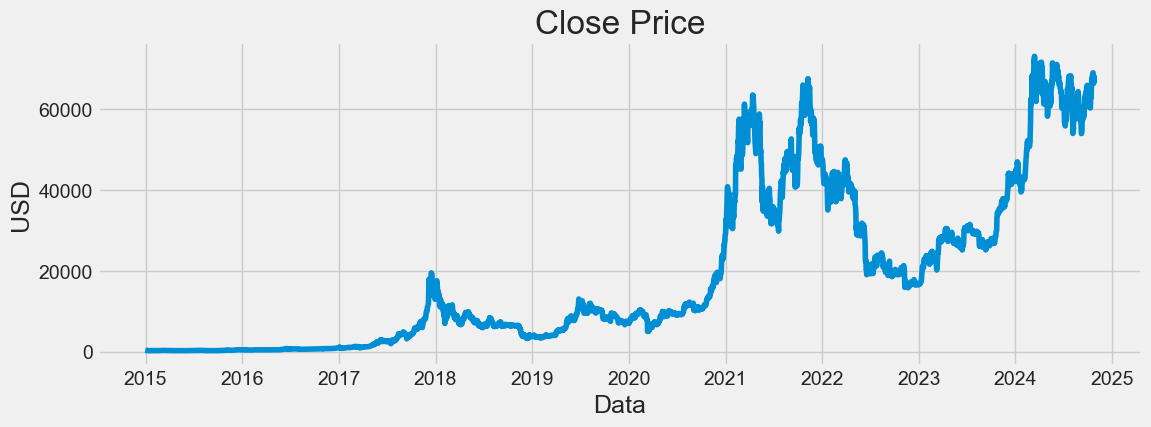

In [9]:
plt.figure(figsize=(12,4))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

## Data Pre-Processing

In [11]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8) # We are using %80 of the data for training
training_data_len

2870

In [118]:
# dump_log_01
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)
with open('training_data_len.pkl', 'wb') as f:
    pickle.dump(training_data_len, f)

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00194896],
       [0.00186749],
       [0.00187819],
       ...,
       [0.90876807],
       [0.93248168],
       [0.9116514 ]])

In [112]:
# dump_log_02
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('scaled_data.pkl', 'wb') as f:
    pickle.dump(scaled_data, f)

In [13]:
train_data = scaled_data[0:training_data_len, :]
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60: i, 0])
  y_train.append(train_data[i, 0])

  if i <= 60:
    print(X_train)
    print(y_train)
    print()

[array([0.00194896, 0.00186749, 0.00187819, 0.00141252, 0.00118098,
       0.00132185, 0.00148261, 0.00159439, 0.00144365, 0.00154049,
       0.00132638, 0.00120101, 0.00123036, 0.0006551 , 0.        ,
       0.00043536, 0.00041149, 0.00029024, 0.00044222, 0.00050422,
       0.00045566, 0.00066936, 0.00075865, 0.00075138, 0.00095672,
       0.00103723, 0.00130813, 0.00117111, 0.00076551, 0.00076003,
       0.00066291, 0.00053988, 0.00067032, 0.00082477, 0.00067444,
       0.00066867, 0.00053508, 0.00060585, 0.00068102, 0.00062149,
       0.00057623, 0.00057252, 0.00056347, 0.00059886, 0.00078636,
       0.00108661, 0.00077799, 0.00076455, 0.00089856, 0.00079871,
       0.00085289, 0.00090089, 0.00091118, 0.00079391, 0.00083382,
       0.00083176, 0.00081434, 0.00080008, 0.00103874, 0.00104464])]
[0.001126116858284846]



In [14]:
len(X_train)

2810

In [15]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2810, 60), (2810,))

In [16]:
test_data = scaled_data[training_data_len - 60 : , :]
X_test = []
y_test = dataset[training_data_len : , :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60 : i, 0])

In [17]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Model-1

In [19]:
tf.random.set_seed(42)
model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) , the simple form is "input_shape(60, 1)""
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dense(25))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mse')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 0.0024
Epoch 2/10
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 7.7061e-04
Epoch 3/10
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 4.3566e-04
Epoch 4/10
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 3.4822e-04
Epoch 5/10
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 3.3139e-04
Epoch 6/10
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 3.1000e-04
Epoch 7/10
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 2.9603e-04
Epoch 8/10
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 2.8323e-04
Epoch 9/10
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 2.7170e-04
Epoch 10/10
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 2.6207e-04


## Model-1 -- Prediction

In [22]:
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
len(predictions_1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


717

In [114]:
# dump_log_03
with open('model_1.pkl', 'wb') as f:
    pickle.dump(model_1, f)
with open('predictions_1.pkl', 'wb') as f:
    pickle.dump(predictions_1, f)

In [23]:
rmse = np.sqrt(np.mean(predictions_1 - y_test)**2)
print(f"Root mean square error is: {rmse}")

Root mean square error is: 1072.5970444342747


<Figure size 400x200 with 0 Axes>

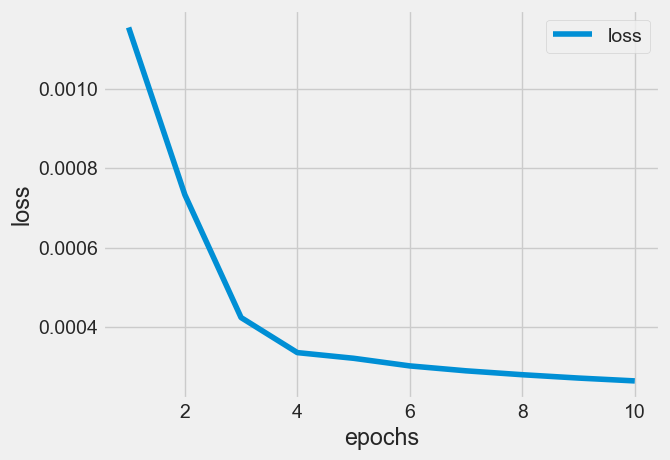

In [24]:
plt.figure(figsize=(4, 2))
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

/var/folders/b2/lvqrh_ls7kv5ml5c2g7djdgw0000gn/T/ipykernel_79089/1113996555.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_1['Predictions'] = predictions_1


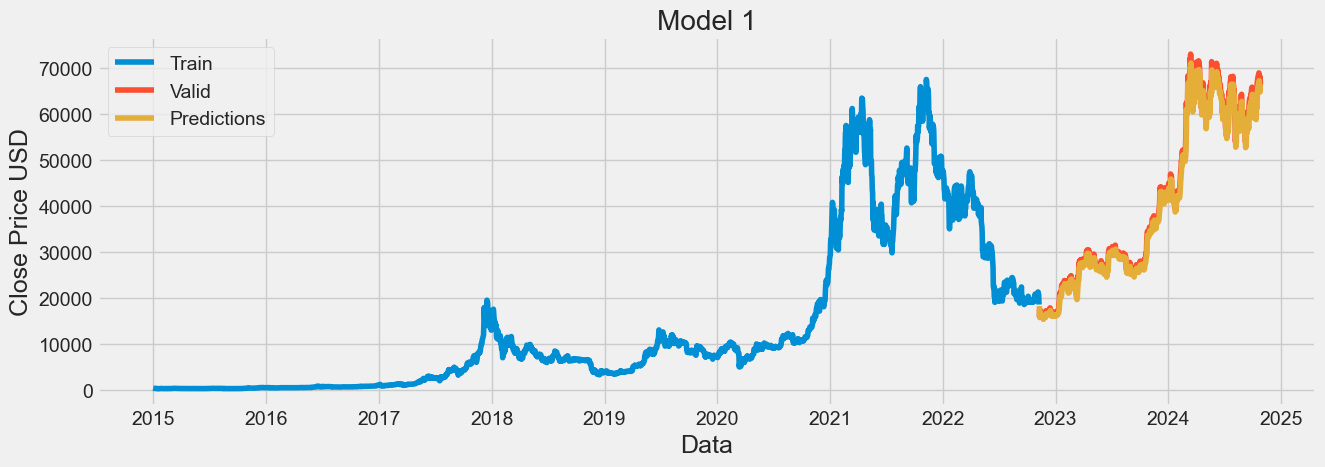

In [25]:
train = data[:training_data_len]

valid_1 = data[training_data_len:]
valid_1['Predictions'] = predictions_1

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model 1')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_1[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')
plt.show()

## Model-2

In [27]:
tf.random.set_seed(42)
model_2 = Sequential()
model_2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) | the simple form is "input_shape(60, 1)
model_2.add(LSTM(50, return_sequences=False))
model_2.add(Dense(25))
model_2.add(Dense(1))
model_2.compile(optimizer='Adam', loss='mse')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history_2 = model_2.fit(X_train, y_train, batch_size=1, epochs=6)

Epoch 1/6
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.0019
Epoch 2/6
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 6.5406e-04
Epoch 3/6
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 4.5906e-04
Epoch 4/6
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 3.7099e-04
Epoch 5/6
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 3.4264e-04
Epoch 6/6
2810/2810 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 3.2074e-04


## Model-2 -- Prediction

In [30]:
predictions_2 = model_2.predict(X_test)
predictions_2 = scaler.inverse_transform(predictions_2)
len(predictions_2)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


717

In [31]:
rmse_2 = np.sqrt(np.mean(predictions_2 - y_test)**2)
print(f"Root mean square error is: {rmse_2}")

Root mean square error is: 912.9754385678174


<Figure size 400x200 with 0 Axes>

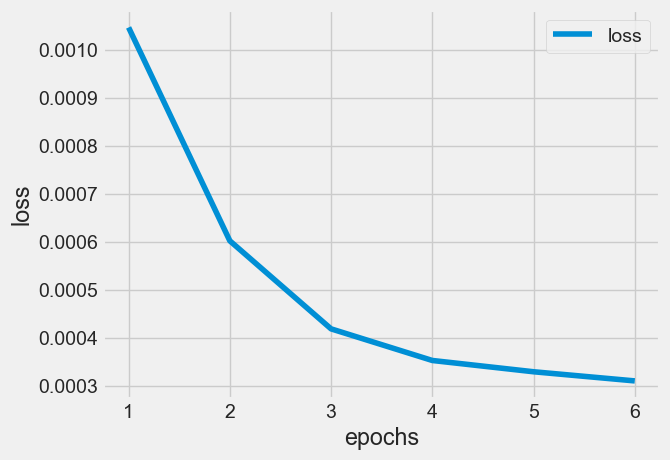

In [32]:
plt.figure(figsize=(4, 2))
historyForPlot = pd.DataFrame(history_2.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

/var/folders/b2/lvqrh_ls7kv5ml5c2g7djdgw0000gn/T/ipykernel_79089/569641431.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_2['Predictions'] = predictions_2


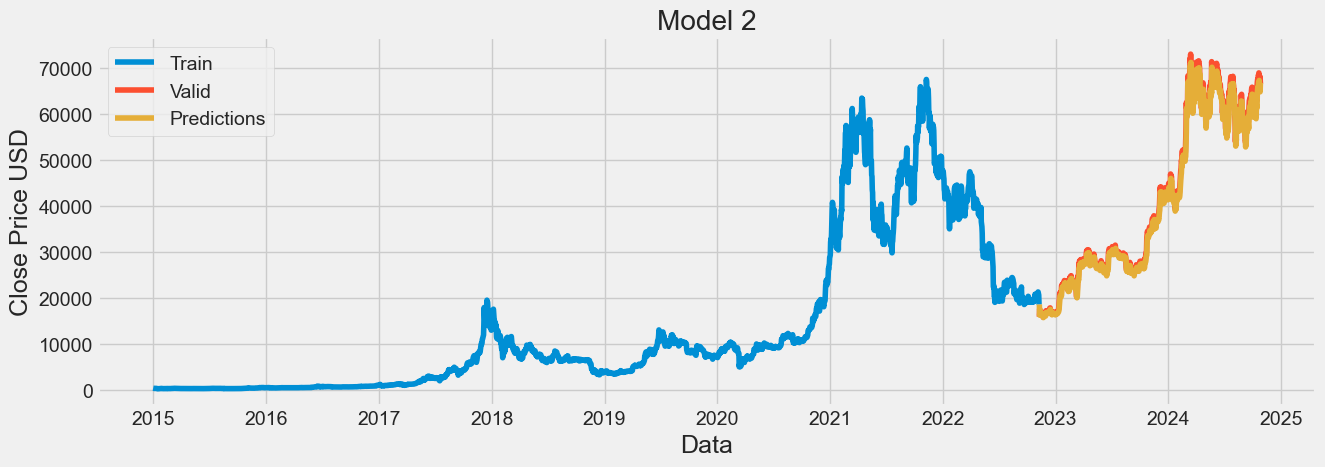

In [33]:
train = data[:training_data_len]

valid_2 = data[training_data_len:]
valid_2['Predictions'] = predictions_2

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model 2')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_2[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')
plt.show()

## Next 5-day BitCoin Price

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


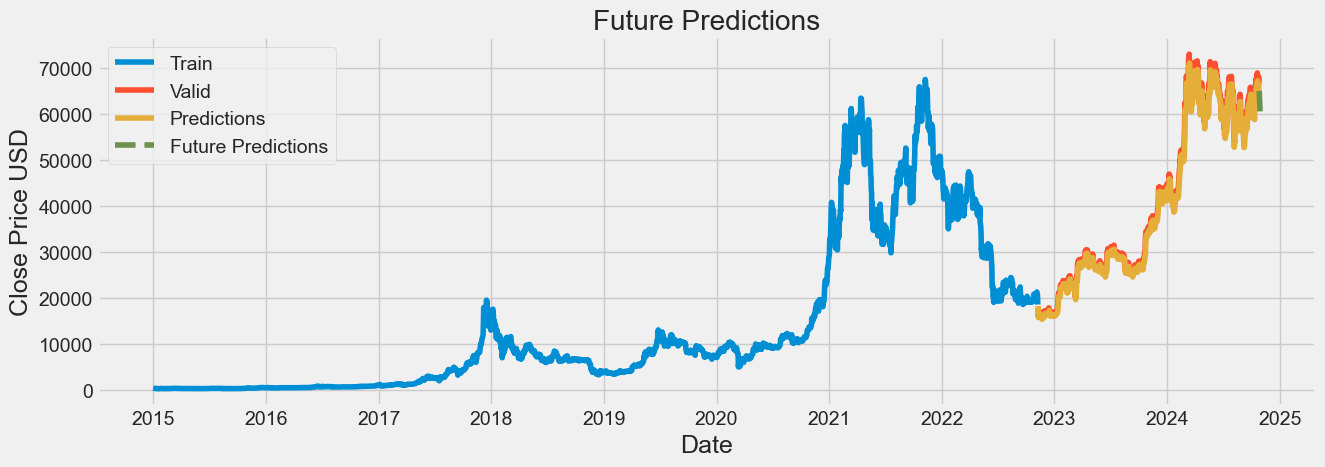

In [90]:
start_index = len(data) - 60
input_sequence = scaled_data[start_index:].tolist()  

future_days = 5

future_predictions = []

for _ in range(future_days):
    pred = model_1.predict(np.array(input_sequence[-60:]).reshape(1, 60, 1))
    future_predictions.append(pred[0, 0])
    input_sequence.append(pred[0])

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

future_dates = pd.date_range(data.index[-1], periods=future_days + 1)[1:] 
future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Predictions'])

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Future Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'], label='Train')
plt.plot(valid_1[['Close', 'Predictions']], label='Validation')
plt.plot(future_df['Predictions'], label='Future Predictions', linestyle='--')
plt.legend(['Train', 'Valid', 'Predictions', 'Future Predictions'], loc='upper left')
plt.show()

In [92]:
print("Next 5 Day Price Predictions:\n")
print(future_df['Predictions'])

Next 5 Day Price Predictions:

2024-10-26    65083.136719
2024-10-27    63469.722656
2024-10-28    61913.917969
2024-10-29    60434.765625
2024-10-30    59019.667969
Freq: D, Name: Predictions, dtype: float32
